# X0-2

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import lightkurve as lk
from glob import glob
import ombre as om
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

In [3]:
name = 'XO-2'

In [4]:
fnames = np.asarray(glob(f'/Volumes/Nibelheim/hst/data/{name}/*.fits'))

In [5]:
from astropy.io import fits
ts = []
for fname in fnames:
    ts.append(fits.getheader(fname)['EXPSTART'])

In [6]:
pixel_mask = np.ones((512, 512))
pixel_mask[130:280] = 0
v1 = om.Visit.from_files(fnames[:43], pixel_mask=pixel_mask, force=True)
obs = om.Observation([v1], name=v1.name)

/Users/ch/HST/projects/ombre/src/ombre/visit.py:208: RuntimeWarning: divide by zero encountered in true_divide
  w[self.err / self.sci > 0.1] = 1e10


In [7]:
obs

XO-2 [1 Visits]

<AxesSubplot:xlabel='Phase', ylabel='$e^-s^{-1}$'>

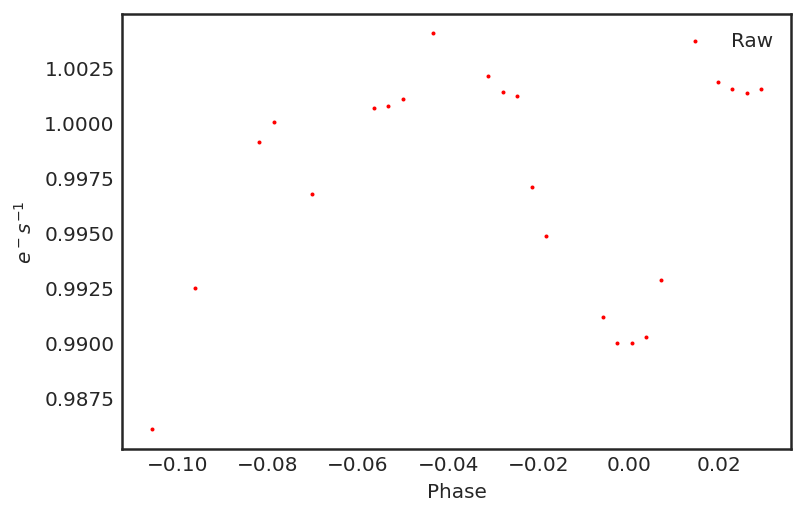

In [8]:
obs.plot()

In [9]:
clc = lk.search_lightcurve(name, author='SPOC', exptime=120).download_all().stitch().remove_nans()
clc.flux = clc.flux.value * u.electron/u.s
clc.flux_err = clc.flux_err.value * u.electron/u.s

<AxesSubplot:xlabel='Phase [JD]', ylabel='Normalized Flux'>

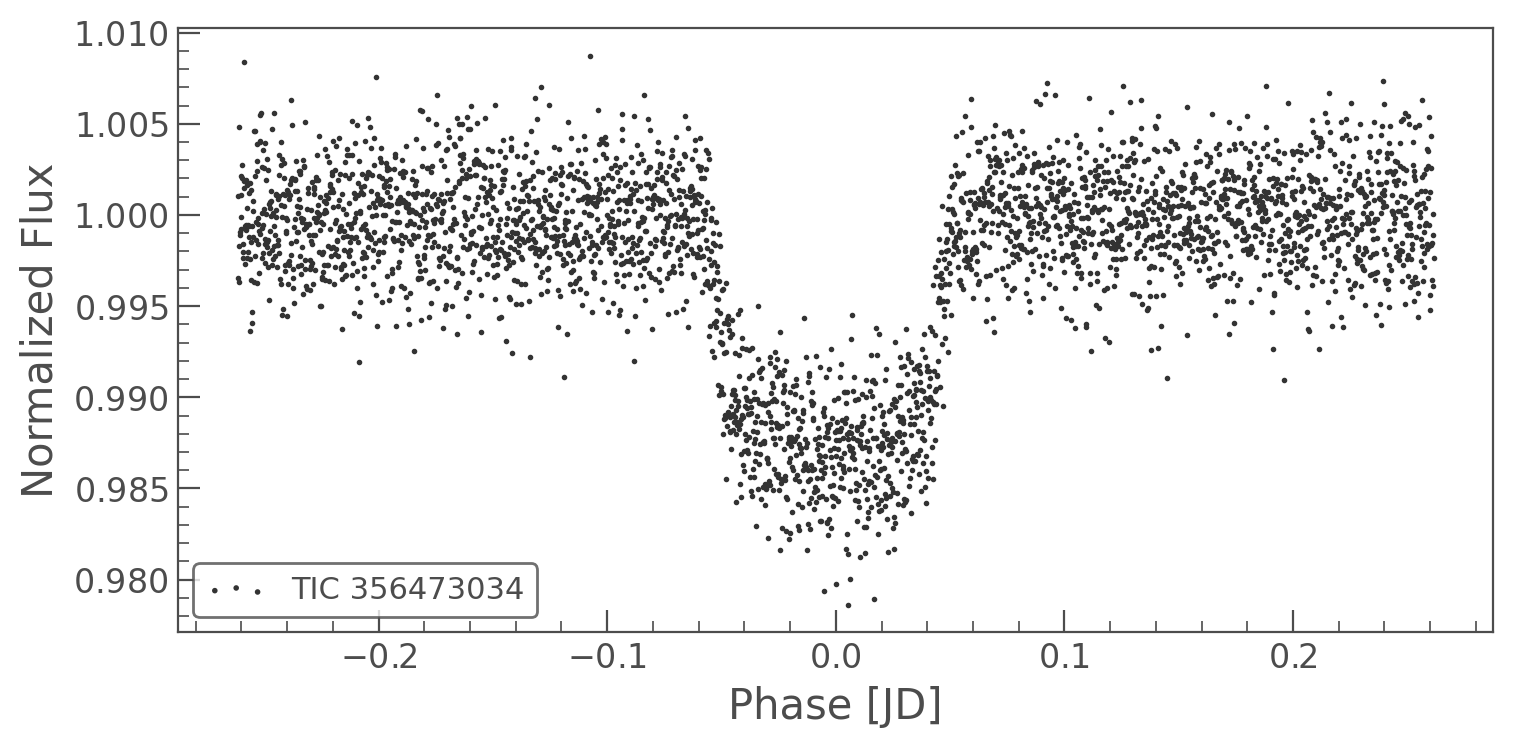

In [10]:
k = np.abs(((clc.time.value - (obs.t0 - 2457000 + obs.period/2))/obs.period) % 1 - 0.5) < 0.1
clc[k].fold(obs.period, obs.t0 - 2457000).scatter()

In [11]:
obs.fit_transit(x_suppl=clc.time.value[k] + 2457000,
                y_suppl=clc.flux.value[k],
                yerr_suppl=clc.flux_err.value[k],
                exptime_suppl=np.median(np.diff(clc.time.value)), fit_t0=True, fit_period=True)

<AxesSubplot:xlabel='Phase', ylabel='$e^-s^{-1}$'>

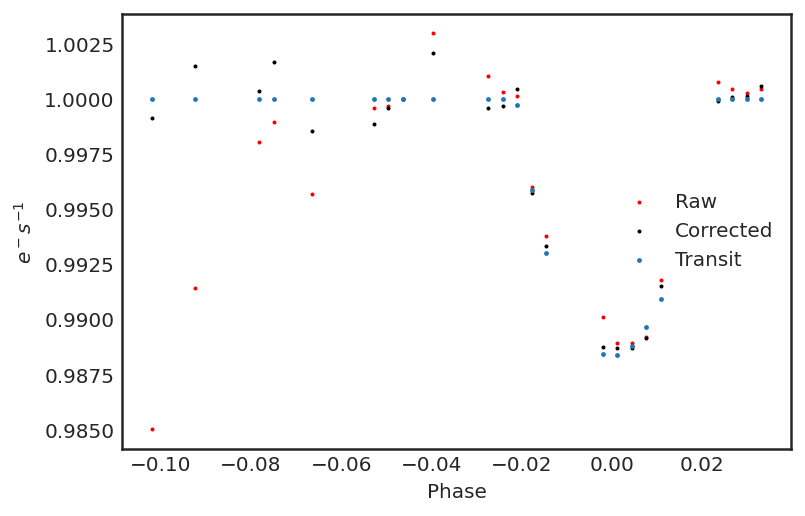

In [12]:
obs.plot()

In [13]:
obs.fit_model()

Fitting Transit/Eclipse Model: 100%|██████████████| 1/1 [00:06<00:00,  6.98s/it]


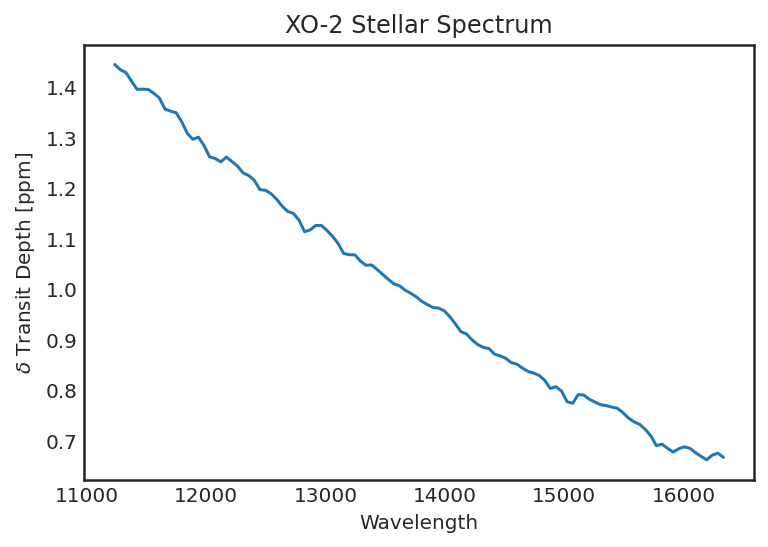

In [14]:
spec = obs.stellar_spectra
spec.plot()
spec.hdulist.writeto(f'results/{name}_stellar_spectrum.fits', overwrite=True)

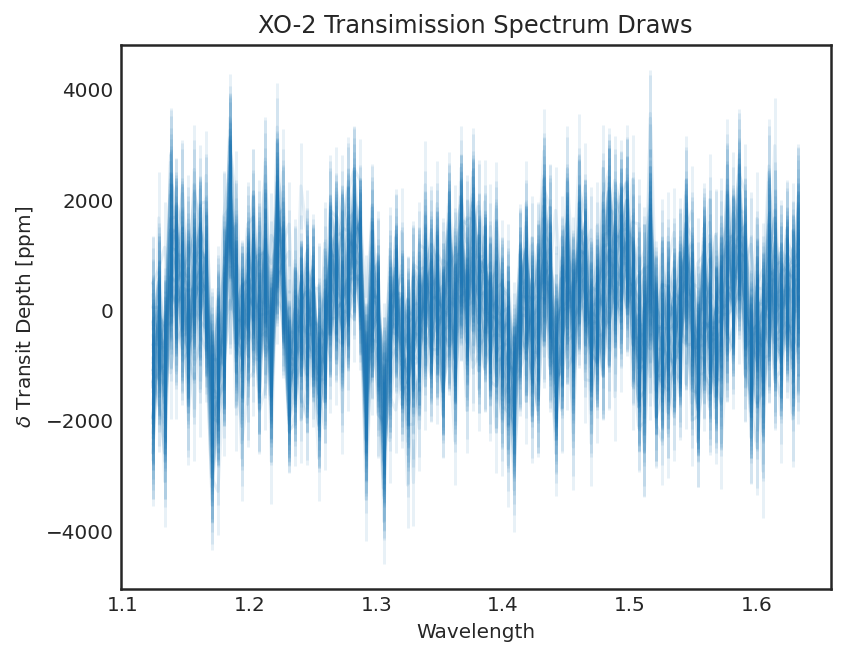

In [15]:
obs.plot_spectra()

[Text(0.5, 1.0, 'WASP-107 Transmission Spectrum')]

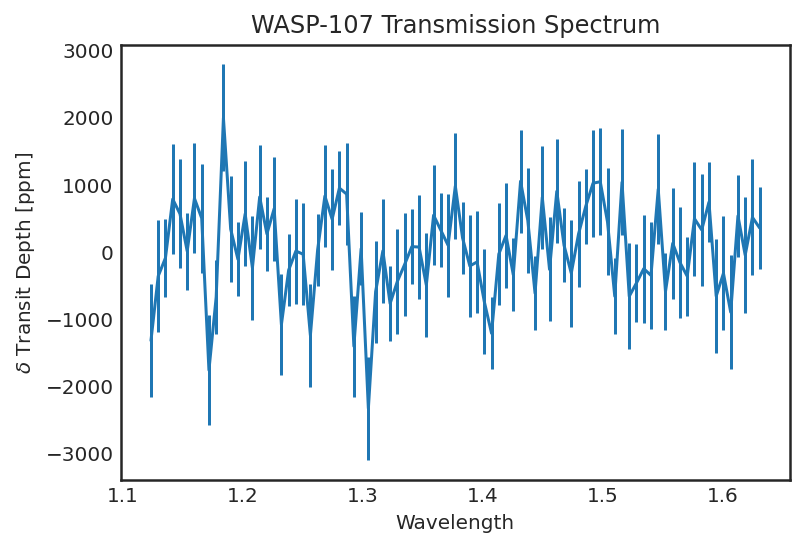

In [16]:
ax = om.Spectra([visit.transmission_spectrum for visit in obs]).flatten().bin(bins=np.linspace(0.8, 1.7, 150)).plot()
ax.set(title='WASP-107 Transmission Spectrum')

In [57]:
from astropy.io import fits
try:
    hdulist = om.Spectra([visit.transmission_spectrum for visit in obs if visit.transmission_spectrum.spec.sum() != 0]).hdulist
    hdulist.writeto(f'results/{name}_transmission.fits', overwrite=True)
except:
    pass
try:    
    hdulist = om.Spectra([visit.emission_spectrum for visit in obs if visit.emission_spectrum.spec.sum() != 0]).hdulist
    hdulist.writeto(f'results/{name}_emission.fits', overwrite=True)
except:
    pass

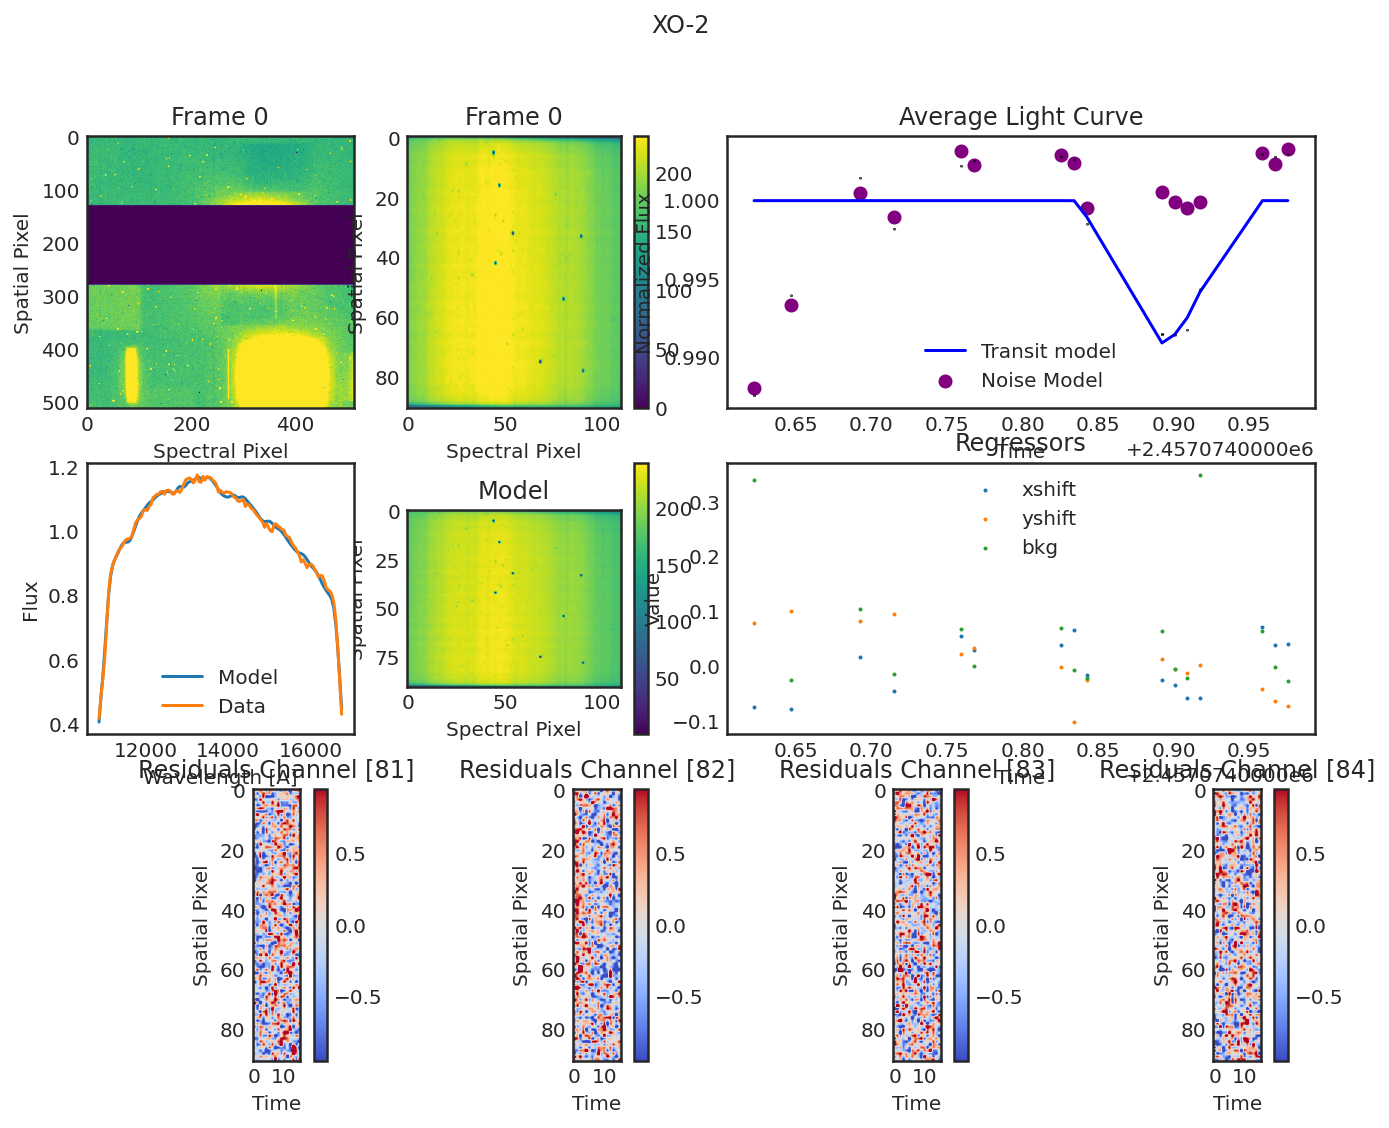

In [58]:
for visit in obs:
    visit.diagnose();
    plt.show();